**Outliers**

In [32]:
import pandas as pd, numpy as np, pathlib, matplotlib.pyplot as plt, joblib, os

TARGET = "Default"  # change if your target column name differs
OUT = pathlib.Path("results/outputs"); OUT.mkdir(parents=True, exist_ok=True)
VIZ = pathlib.Path("results/eda_visualizations"); VIZ.mkdir(parents=True, exist_ok=True)

def _try(p): return p if p.exists() else None

p_train = _try(OUT/"train_missing_handled.csv") or _try(OUT/"train_split.csv") or _try(OUT/"train_balanced_over.csv")
p_val   = _try(OUT/"val_missing_handled.csv")   or _try(OUT/"val_split.csv")
p_test  = _try(OUT/"test_missing_handled.csv")  or _try(OUT/"test_split.csv")

assert p_train and p_val and p_test, "Could not find split files. Run the split/missing steps first."

train = pd.read_csv(p_train)
val   = pd.read_csv(p_val)
test  = pd.read_csv(p_test)

assert TARGET in train.columns, f"{TARGET} not found."

print("Loaded:", p_train, p_val, p_test, sep="\n- ")

Loaded:
- results/outputs/train_missing_handled.csv
- results/outputs/val_missing_handled.csv
- results/outputs/test_missing_handled.csv


In [33]:
num_cols = train.drop(columns=[TARGET]).select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", len(num_cols))

def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    return low, high, iqr

rows = []
for c in num_cols:
    low, high, iqr = iqr_bounds(train[c].dropna())
    skew = train[c].dropna().skew()
    share_low  = (train[c] < low).mean()
    share_high = (train[c] > high).mean()
    rows.append(dict(column=c, q1_low=low, q3_high=high, iqr=iqr, skew=skew,
                     frac_below=share_low, frac_above=share_high,
                     frac_outliers=share_low+share_high))

outlier_table = pd.DataFrame(rows).sort_values("frac_outliers", ascending=False)
display(outlier_table.head(15))
outlier_table.to_csv(OUT/"outlier_summary_train.csv", index=False)
print("Saved:", OUT/"outlier_summary_train.csv")


Numeric columns: 7


,column,q1_low,q3_high,iqr,skew,frac_below,frac_above,frac_outliers
6,ExistingDebt,-19913.500,44994.500,16227.00,0.868121,0.0,0.006961,0.006961
1,Age,-10.500,97.500,27.00,0.027165,0.0,0.000000,0.000000
0,CustomerID,-468.000,1490.000,489.50,-0.065757,0.0,0.000000,0.000000
2,AnnualIncome,-8127.875,158203.125,41582.75,-0.126631,0.0,0.000000,0.000000
3,LoanAmount,-17701.625,70961.375,22165.75,0.069786,0.0,0.000000,0.000000
4,CreditScore,63.000,1119.000,264.00,-0.227344,0.0,0.000000,0.000000
5,LoanTerm,-12.000,84.000,24.00,-0.064524,0.0,0.000000,0.000000


Saved: results/outputs/outlier_summary_train.csv


Top columns with outliers: ['ExistingDebt']


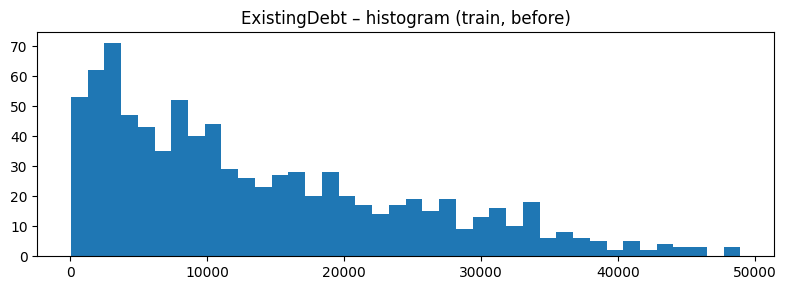

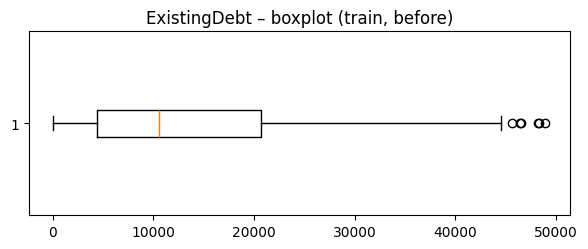

In [34]:
top_cols = outlier_table.query("frac_outliers>0").head(4)["column"].tolist()
print("Top columns with outliers:", top_cols)

for c in top_cols:
    fig = plt.figure(figsize=(8,3))
    plt.hist(train[c].dropna(), bins=40)
    plt.title(f"{c} – histogram (train, before)")
    plt.tight_layout(); plt.savefig(VIZ/f"hist_before_{c}.png", dpi=150); plt.show()

    fig = plt.figure(figsize=(6,2.6))
    plt.boxplot(train[c].dropna(), vert=False)
    plt.title(f"{c} – boxplot (train, before)")
    plt.tight_layout(); plt.savefig(VIZ/f"box_before_{c}.png", dpi=150); plt.show()


In [35]:
# build per-column caps from TRAIN
caps = {c: iqr_bounds(train[c].dropna())[:2] for c in num_cols}  # {col: (low, high)}

def cap_df(df):
    df2 = df.copy()
    for c in num_cols:
        low, high = caps[c]
        df2[c] = df2[c].clip(lower=low, upper=high)
    return df2

train_cap = cap_df(train.drop(columns=[]))
val_cap   = cap_df(val.drop(columns=[]))
test_cap  = cap_df(test.drop(columns=[]))

# Save capped datasets
train_cap.to_csv(OUT/"train_outliers_capped.csv", index=False)
val_cap.to_csv(OUT/"val_outliers_capped.csv", index=False)
test_cap.to_csv(OUT/"test_outliers_capped.csv", index=False)
joblib.dump(caps, OUT/"outlier_caps_iqr.pkl")
print("Saved capped datasets and caps:", OUT/"train_outliers_capped.csv", OUT/"val_outliers_capped.csv", OUT/"test_outliers_capped.csv")


Saved capped datasets and caps: results/outputs/train_outliers_capped.csv results/outputs/val_outliers_capped.csv results/outputs/test_outliers_capped.csv


Outlier fraction before (top 10):


,frac_outliers
column,
ExistingDebt,0.006961
Age,0.000000
CustomerID,0.000000
AnnualIncome,0.000000
LoanAmount,0.000000
CreditScore,0.000000
LoanTerm,0.000000



Outlier fraction AFTER capping (train):


,0
CustomerID,0.0
Age,0.0
AnnualIncome,0.0
LoanAmount,0.0
CreditScore,0.0
LoanTerm,0.0
ExistingDebt,0.0


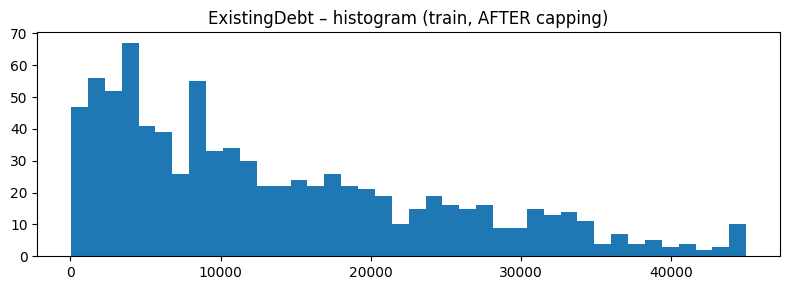

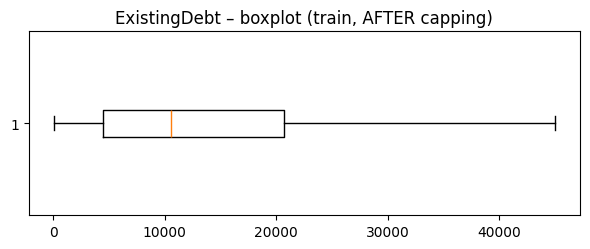

In [36]:
def frac_outliers_after(df, caps):
    fracs = {}
    for c in num_cols:
        low, high = caps[c]
        fracs[c] = ((df[c] < low) | (df[c] > high)).mean()
    return pd.Series(fracs).sort_values(ascending=False)

print("Outlier fraction before (top 10):")
display(outlier_table.set_index("column")["frac_outliers"].head(10))
print("\nOutlier fraction AFTER capping (train):")
display(frac_outliers_after(train_cap, caps).head(10))

for c in top_cols:
    fig = plt.figure(figsize=(8,3))
    plt.hist(train_cap[c].dropna(), bins=40)
    plt.title(f"{c} – histogram (train, AFTER capping)")
    plt.tight_layout(); plt.savefig(VIZ/f"hist_after_{c}.png", dpi=150); plt.show()

    fig = plt.figure(figsize=(6,2.6))
    plt.boxplot(train_cap[c].dropna(), vert=False)
    plt.title(f"{c} – boxplot (train, AFTER capping)")
    plt.tight_layout(); plt.savefig(VIZ/f"box_after_{c}.png", dpi=150); plt.show()
